# Restaking EL-rewards evaluation

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

# Annual rates
staking_APR = 4.5
mev_tx_APR = 4.5
simple_APR = staking_APR + mev_tx_APR

# Daily
staking_DPR = staking_APR / 365.
mev_tx_DPR = mev_tx_APR / 365.
simple_DPR = staking_DPR + mev_tx_DPR

# Verification stake
initial_stake = 320

years = 3.

# Day 0: entry point
days = round(years * 365.) + 1

x = np.zeros(days)
for d in range(days):
    x[d] = d

## Straightforward benchmark (without reinvesting)

$y\_benchmark_{day} = initial\_stake * (1. + day \frac{simple\_DPR}{100})$

In [10]:
# Benchmark goes without restaking

y_benchmark = np.zeros(days)

for day in range(days):
    y_benchmark[day] = initial_stake * (1. + day * simple_DPR/100.)

## Restaking scheme (compound interest for the EL-rewards)

$\begin{align}
y\_restaking_{0} = initial\_stake \\
\\
y\_restaking_{day} = y\_restaking_{day-1} + initial\_stake * (\frac{simple\_DPR}{100}) * (1 + \frac{mev\_tx\_DPR}{100})^{day} 
\end{align}$

In [3]:
# Balances with restaking

y_restaking = np.zeros(days)
y_restaking[0] = initial_stake

for d in range(1, days):
    day_d_stake = initial_stake * (1+mev_tx_DPR / 100.)**d
    day_d_delta = simple_DPR / 100. * day_d_stake
    y_restaking[d] = y_restaking[d-1] + day_d_delta    

### Plots

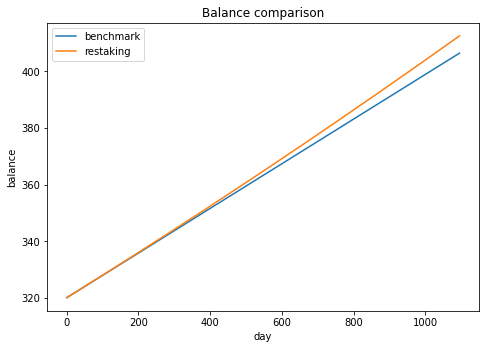

In [12]:
fig=plt.figure()
ax=fig.add_axes([0, 0, 1, 1])
ax.plot(x,y_benchmark, label="benchmark")
ax.plot(x,y_restaking, label="restaking")
ax.set_title("Balance comparison")
ax.set_xlabel("day")
ax.set_ylabel("balance")
ax.legend()

## Overall results

In [13]:
print(f"final benchmark balance: {y_benchmark[days-1]}")
print(f"final restaking balance: {y_restaking[days-1]}")

b_APR = (y_benchmark[days-1]-initial_stake)/initial_stake * 100. / ((days-1) / 365.)
print(f"benchmark APR: {b_APR:.2f}%")

r_APY = (y_restaking[days-1]-initial_stake)/initial_stake * 100. / ((days-1) / 365.)
print(f"restaking APY: {r_APY:.2f}%")

print(f"APY/APR diff: {r_APY-b_APR:.2f}%")

final benchmark balance: 406.4
final restaking balance: 412.5088504717104
benchmark APR: 9.00%
restaking APY: 9.64%
APY/APR diff: 0.64%
